### MultiModality RAG
- MultiModal -> Text + Images
- It's about designing how to extract, embed and store multi modality data
- Then retrieve similar content based on query using RAG.

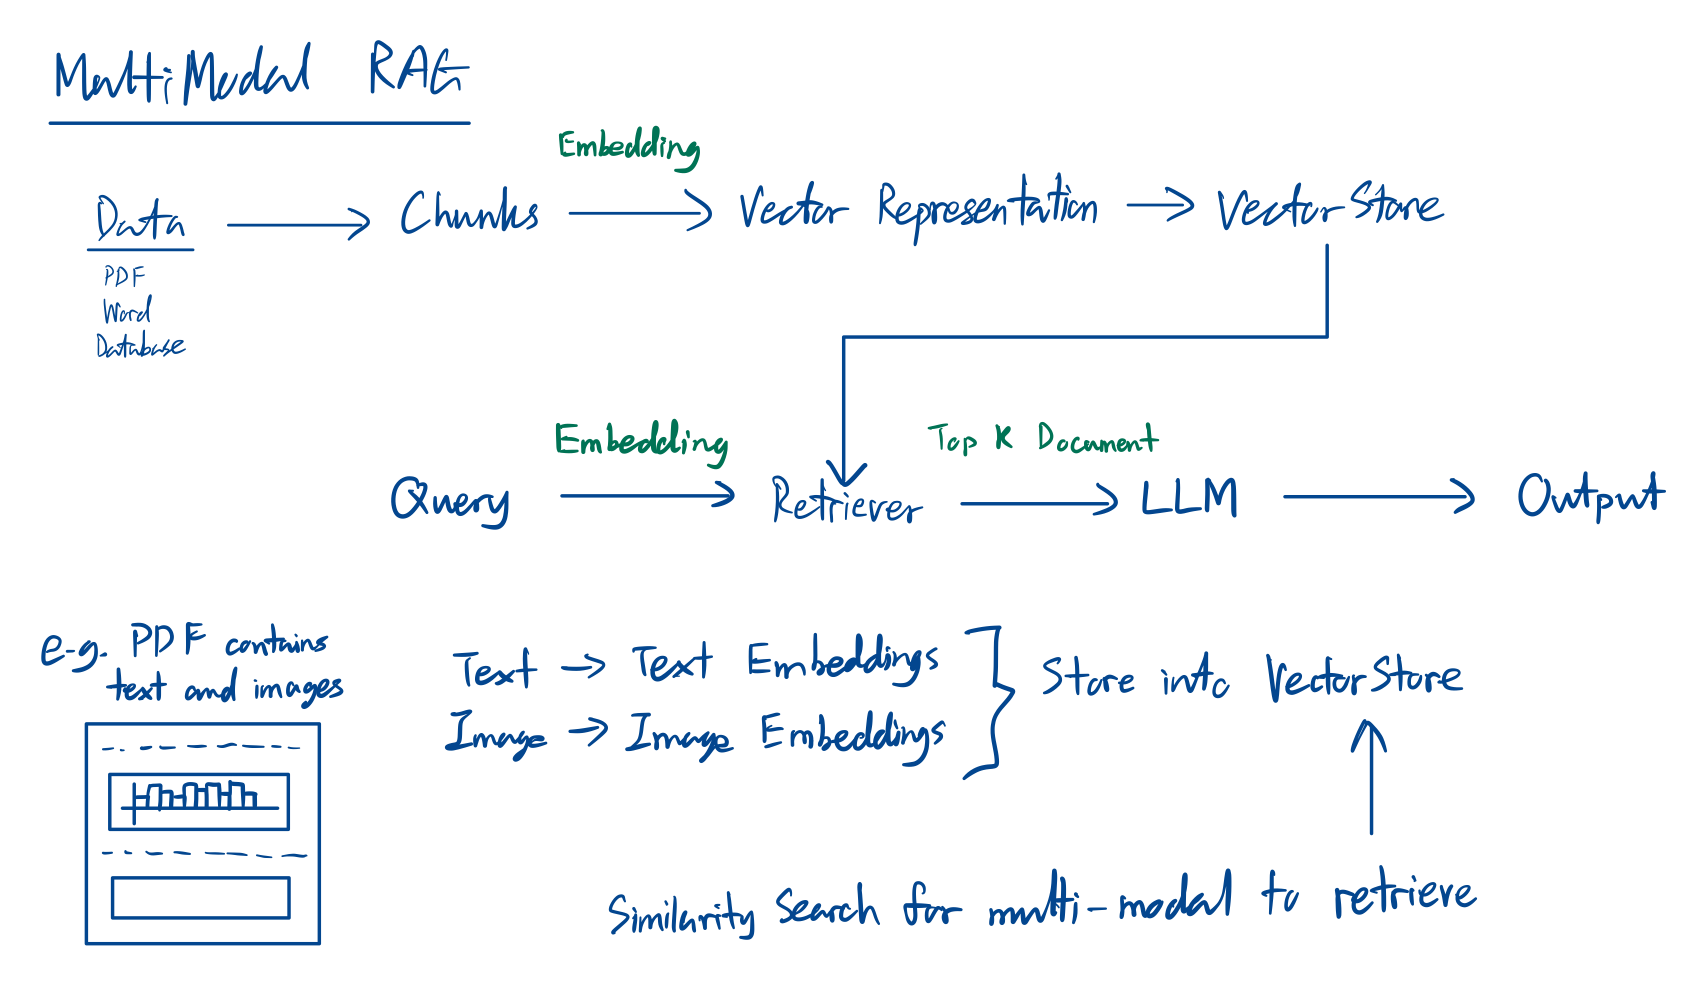

- For this use case, we have to use `MultiModal LLM`, e.g. GPT-4.1, gemini-2.5-flash
- Steps to achieve this:
    1. From the PDF input, extract text and images
    2. From the text, convert them into chunks and perform embeddings
    3. From the images, perform embeddings, store them into base64 format.
    4. Store the embeddings into a VectorStore. e.g. FAISS VectorStore
- For each query, we follow these steps for retrieval:
    1. Convert query into embedding.
    2. Perform Vector Search for Top K Documents (Text + Images)
    3. Convert into specific format required by MultiModal LLM before sending to LLM.
    4. LLM will generate and provide output.
- We could use different embeddings, one for for text and the other for image. In this use case, we make use of a single embedding model for both text and image. We will use `CLIP` model.

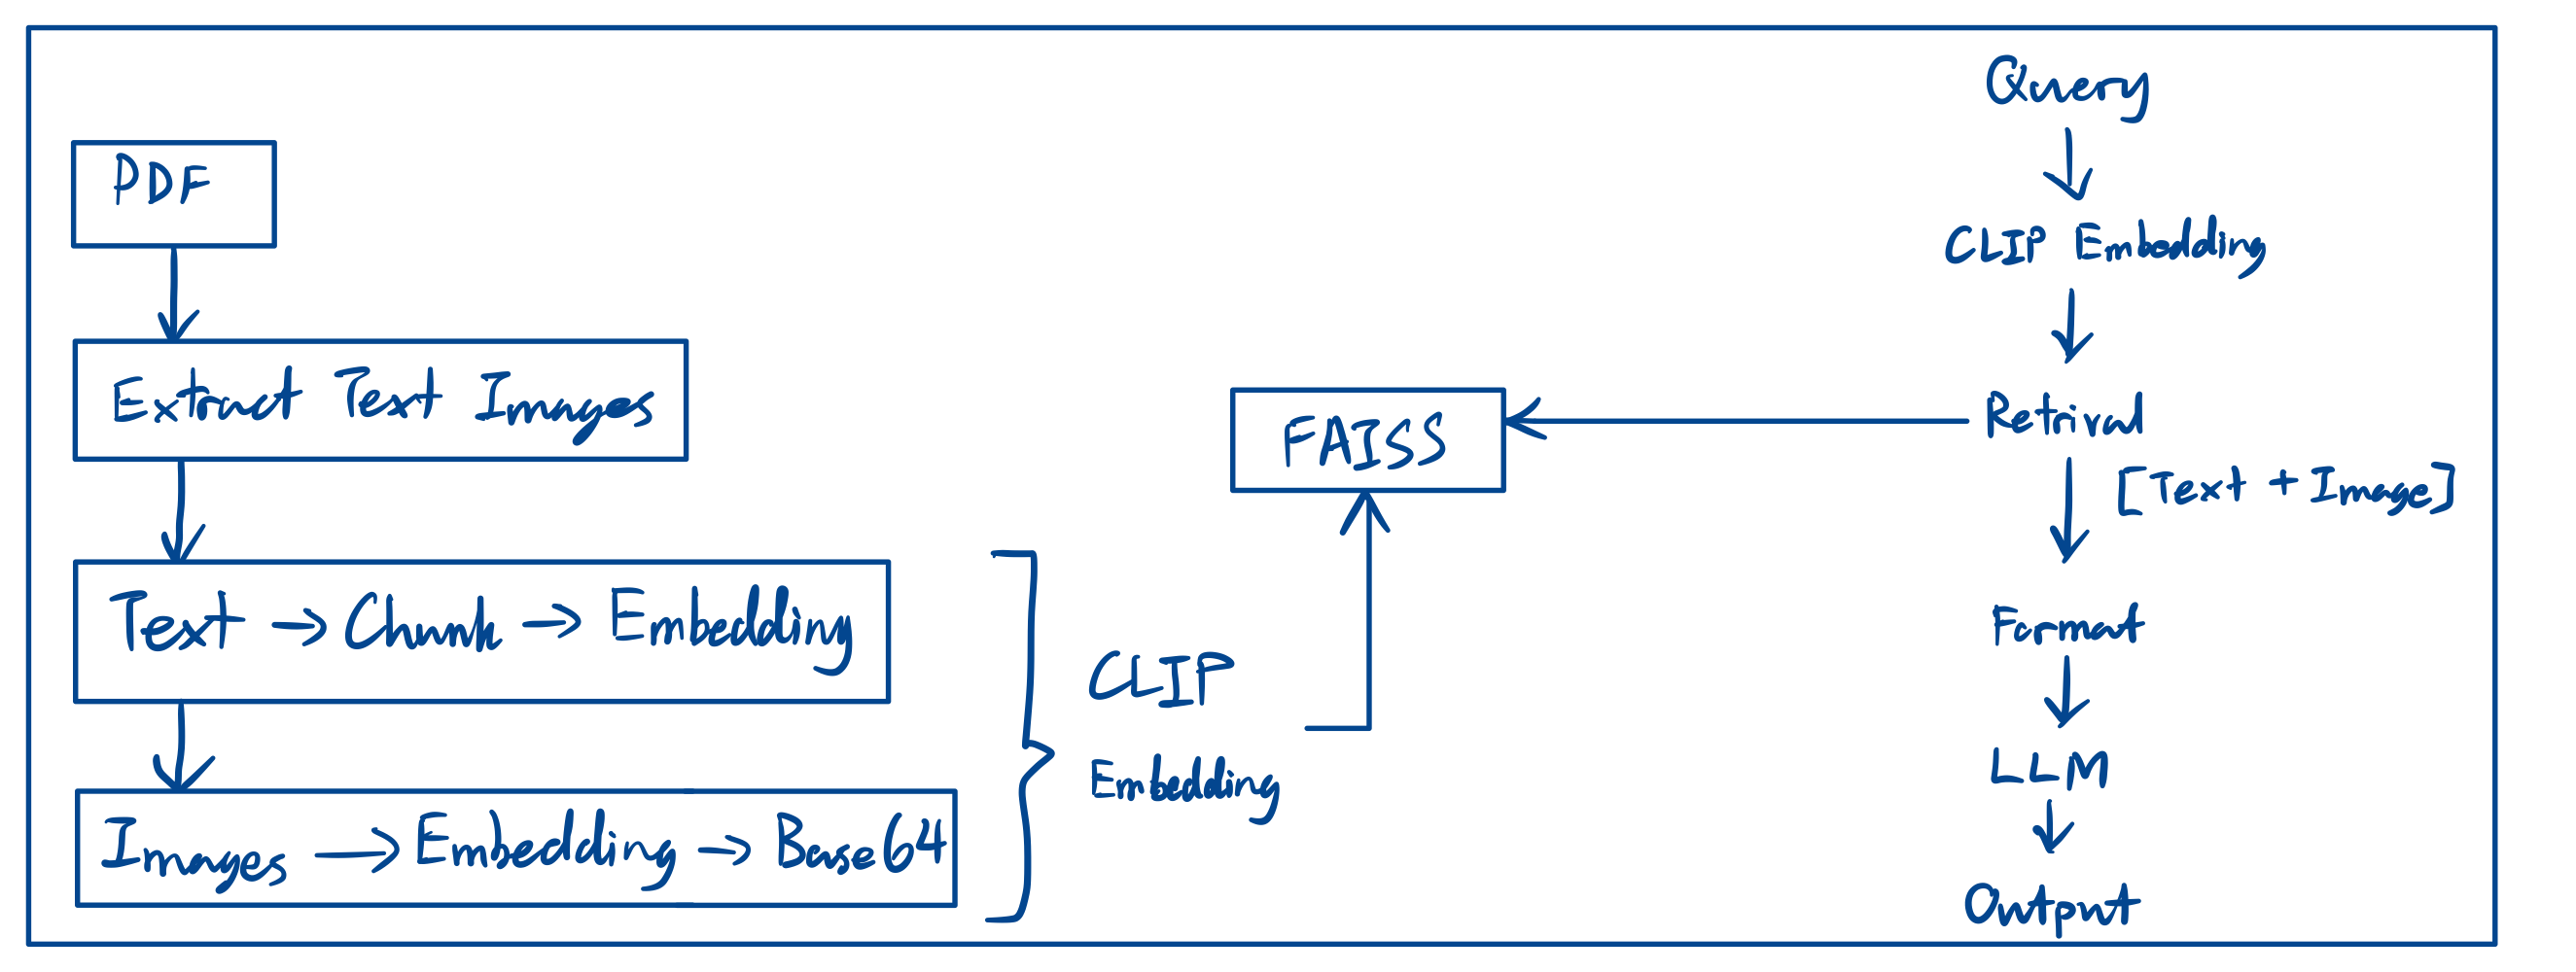

In [1]:
import fitz ### PyMuPDF
from langchain_core.documents import Document
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np
from langchain.chat_models import init_chat_model
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage
from sklearn.metrics.pairwise import cosine_similarity
import os
import base64
import io
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from dotenv import load_dotenv
load_dotenv()

/Users/kuanyongsoo/Desktop/Desktop - Kuan’s MacBook Air/KY/school/SWE5008 Architecting AI Systems/AI Agent tutorial/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
### CLIP Model
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')

### Initialise the CLIP model for unified embeddings
clip_model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
clip_processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32') ### Responsible for converting input to match format required for CLIP model
clip_model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [3]:
### Embedding Function
def embed_image(image_data):
    """
    Embed image using CLIP
    """
    if isinstance(image_data, str): ### If path provided
        image = Image.open(image_data).convert('RGB')
    else: ### If PIL Image provided
        image = image_data
    
    inputs = clip_processor(images=image, return_tensors='pt') ### Return in pytorch tensors
    with torch.no_grad():
        features = clip_model.get_image_features(**inputs)
        ### Normalise embeddings to unit vectors
        features = features / features.norm(dim=-1, keepdim=True)
        return features.squeeze().numpy()

def embed_text(text):
    """
    Embed text using CLIP
    """
    inputs = clip_processor(
        text=text,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=77       ### CLIP's max token length
    )
    with torch.no_grad():
        features = clip_model.get_text_features(**inputs)
        ### Normalise embeddings to unit vectors
        features = features / features.norm(dim=-1, keepdim=True)
        return features.squeeze().numpy()

In [4]:
### Process PDF
pdf_path = './multimodal_sample.pdf'
doc = fitz.open(pdf_path)

### Store all documents and embeddings
all_docs = []
all_embeddings = []
image_data_store = {}   ### Store actual image data for LLM

### Text Splitter
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

In [5]:
doc

Document('./multimodal_sample.pdf')

In [6]:
for i, page in enumerate(doc):
    ### Process text
    text = page.get_text()
    if text.strip():
        ### Create temporary document for splitting
        temp_doc = Document(page_content=text, metadata={'page': i, 'type': 'text'})
        text_chunks = splitter.split_documents([temp_doc])
        ### Embed each chunk using CLIP
        for chunk in text_chunks:
            embedding = embed_text(chunk.page_content)
            all_embeddings.append(embedding)
            all_docs.append(chunk)

    ### Process image
    """
    Three important actions:
    1. Convert PDF Image to PIL format
    2. Store as base64 for GPT-4V (which needs base64 images)
    3. Create CLIP embedding for retrieval
    """
    for img_index, img in enumerate(page.get_images(full=True)):
        try:
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image['image']

            ### Convert to PIL Image
            pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

            ### Create unique identifier
            image_id = f'page_{i}_img_{img_index}'

            ### Store image as base64 for later use with GPT-4V
            buffered = io.BytesIO()
            pil_image.save(buffered, format='PNG')
            img_base64 = base64.b64encode(buffered.getvalue()).decode()
            image_data_store[image_id] = img_base64

            ### Embed image using CLIP
            embedding = embed_image(pil_image)
            all_embeddings.append(embedding)
            
            ### Create document for image
            image_doc = Document(
                page_content = f'[Image: {image_id}]',
                metadata = {'page': i, 'type': 'image', 'image_id': image_id}
            )
            all_docs.append(image_doc)
        
        except Exception as e:
            print(f'Error processing image {img_index} on page {i}: {e}')
            continue
doc.close()

In [7]:
all_docs

[Document(metadata={'page': 0, 'type': 'text'}, page_content='Annual Revenue Overview\nThis document summarizes the revenue trends across Q1, Q2, and Q3. As illustrated in the chart\nbelow, revenue grew steadily with the highest growth recorded in Q3.\nQ1 showed a moderate increase in revenue as new product lines were introduced. Q2 outperformed\nQ1 due to marketing campaigns. Q3 had exponential growth due to global expansion.'),
 Document(metadata={'page': 0, 'type': 'image', 'image_id': 'page_0_img_0'}, page_content='[Image: page_0_img_0]')]

In [8]:
### Create FAISS Vector Store with CLIP embeddings
embedding_array = np.array(all_embeddings)
embedding_array

array([[-0.00267244,  0.01282994, -0.05183146, ..., -0.00385089,
         0.02977717, -0.00010689],
       [ 0.01732345, -0.01327708, -0.02427041, ...,  0.08993969,
        -0.00272156,  0.03253062]], shape=(2, 512), dtype=float32)

In [9]:
(all_docs, embedding_array)

([Document(metadata={'page': 0, 'type': 'text'}, page_content='Annual Revenue Overview\nThis document summarizes the revenue trends across Q1, Q2, and Q3. As illustrated in the chart\nbelow, revenue grew steadily with the highest growth recorded in Q3.\nQ1 showed a moderate increase in revenue as new product lines were introduced. Q2 outperformed\nQ1 due to marketing campaigns. Q3 had exponential growth due to global expansion.'),
  Document(metadata={'page': 0, 'type': 'image', 'image_id': 'page_0_img_0'}, page_content='[Image: page_0_img_0]')],
 array([[-0.00267244,  0.01282994, -0.05183146, ..., -0.00385089,
          0.02977717, -0.00010689],
        [ 0.01732345, -0.01327708, -0.02427041, ...,  0.08993969,
         -0.00272156,  0.03253062]], shape=(2, 512), dtype=float32))

In [10]:
### Create custom FAISS index since we have precomputed embeddings
vector_store = FAISS.from_embeddings(
    text_embeddings=[(doc.page_content, emb) for doc, emb in zip(all_docs, embedding_array)],
    embedding=None, ### Since we are using precomputed embeddings
    metadatas=[doc.metadata for doc in all_docs]
)
vector_store

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


In [11]:
### Initialise GPT-4 Vision Model
# llm = init_chat_model('openai:o4-mini')
llm = init_chat_model('google_genai:gemini-2.5-flash')
llm

ChatGoogleGenerativeAI(model='models/gemini-2.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x162da82f0>, default_metadata=(), model_kwargs={})

In [12]:
llm.invoke('Hi')

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--7d2eebcf-8383-4f23-8832-a9600e4a339a-0', usage_metadata={'input_tokens': 2, 'output_tokens': 38, 'total_tokens': 40, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 29}})

In [16]:
def retrieve_multimodal(query, k=5):
    """
    Unified retrieval using CLIP embeddings for both text and images.
    """
    query_embedding = embed_text(query) ### Embed query using CLIP

    ### Search based on query embeddings
    results = vector_store.similarity_search_by_vector(
        embedding=query_embedding,
        k=k
    )

    return results

In [29]:
def create_multi_modal_message(query, retrieved_docs):
    """
    Create a message with both text and images for GPT-4V
    """
    content = []

    ### Add the query
    content.append({
        'type': 'text',
        'text': f'Question: {query}\n\nContext:\n'
    })

    ### Separate text and image documents
    text_docs = [doc for doc in retrieved_docs if doc.metadata.get('type') == 'text']
    image_docs = [doc for doc in retrieved_docs if doc.metadata.get('type') == 'image']

    ### Add text context
    if text_docs:
        text_context = '\n\n'.join([
            f'[Page {doc.metadata['page']}]: {doc.page_content}'
            for doc in text_docs
        ])
        content.append({
            'type': 'text',
            'text': f'Text excerpts:\n{text_context}\n'
        })
    
    ### Add image context
    for doc in image_docs:
        image_id = doc.metadata.get('image_id')
        if image_id and image_id in image_data_store:
            content.append({
                'type': 'text',
                'text': f'\n[Image from page {doc.metadata['page']}]:\n'
            })
            content.append({
                'type': 'image_url',
                'image_url': {
                    'url': f'data:image/png;base64, {image_data_store[image_id]}'
                }
            })
    
    ### Add instruction
    content.append({
        'type': 'text',
        'text': '\n\nPlease answer the question based on the provided text and images.'
    })

    return HumanMessage(content=content)

In [30]:
def multi_modal_pdf_rag_pipeline(query):
    """
    Main pipeline for multimodal RAG
    """
    ### Retrieve relevant documents
    context_docs = retrieve_multimodal(query, k=5)

    ### Create multimodal message
    message = create_multi_modal_message(query, context_docs)

    ### Get response from GPT-4V
    response = llm.invoke([message])

    ### Print retrieved context information
    print(f'\nRetrived {len(context_docs)} documents:')
    for doc in context_docs:
        doc_type = doc.metadata.get('type', 'unknown')
        page = doc.metadata.get('page', '?')
        if doc_type == 'text':
            preview = doc.page_content[:100] + '...' if len(doc.page_content) > 100 else doc.page_content
            print(f'    - Text from page {page}: {preview}')
        else:
            print(f'    - Image from page {page}')
    print('\n')

    return response.content

In [31]:
### Example queries
queries = ['What does the chart on page 1 show about revenue trends?',
           'Summarise the main findings from the document'
           'What visual elements are present in the document?']

for query in queries:
    print(f'\nQuery: {query}')
    print('-'*50)
    answer = multi_modal_pdf_rag_pipeline(query)
    print(f'Answer: {answer}')
    print('='*70)


Query: What does the chart on page 1 show about revenue trends?
--------------------------------------------------

Retrived 2 documents:
    - Text from page 0: Annual Revenue Overview
This document summarizes the revenue trends across Q1, Q2, and Q3. As illust...
    - Image from page 0


Answer: The chart on page 0 (referred to as page 1 in the question) is a bar chart that visually represents the revenue trends across Q1, Q2, and Q3.

It shows that:
*   Revenue grew steadily from Q1 to Q3.
*   Q1 had the lowest revenue (represented by the blue bar).
*   Q2 outperformed Q1, showing higher revenue than Q1 (represented by the taller green bar).
*   Q3 had the highest revenue, demonstrating the most significant growth (represented by the tallest red bar).

Query: Summarise the main findings from the documentWhat visual elements are present in the document?
--------------------------------------------------

Retrived 2 documents:
    - Text from page 0: Annual Revenue Overview
This doc